In [1]:
import os
os.chdir("../../../")

import pandas as pd
import numpy as np

In [2]:
folderpath = os.getcwd() + "/data/text/solomon_islands/"

def process_data(filename, folderpath=folderpath):
    df = pd.read_csv(folderpath + filename).drop("Unnamed: 0", axis=1)
    df["news"] = df["news"].str.lower()
    df["date"] = pd.to_datetime(df["date"])
    df["ym"] = [str(d.year) + "-" + str(d.month) for d in df.date]
    return df

def get_news_count(data: pd.DataFrame, column: str):
    count_df = (data.set_index("date")
                .groupby("ym")[[str(column)]]
                .count()
                .reset_index()
                .rename({str(column): str(column) + "_count"}, axis=1))
    return count_df

def check_epu_category(row, terms):
    return any([word in str(row) for word in terms])

def get_epu_zscore(data: pd.DataFrame) -> pd.Series:
    ratio = data["epu_count"] / data["news_count"]
    mean, std = ratio.mean(), ratio.std()
    z_score = abs(ratio - mean) / std
    return z_score

In [3]:
ss = process_data("solomon_stars_news.csv")
st = process_data("solomon_times_news.csv")
tis = process_data("island_sun_news.csv")
sibc = process_data("sibc_news.csv")

In [4]:
mindate = min(st.date.min(), ss.date.min(), tis.date.min())
maxdate = max(st.date.max(), st.date.max(),  tis.date.max())
start = str(mindate.year) + "-" + str(mindate.month)
end = str(maxdate.year) + "-" + str(maxdate.month)

In [5]:
econ_lst = [
    "economy", "economic", "economics", "business", "commerce", "finance",
    "financial", "industry"
]

uncertain_lst = [
    "uncertain", "uncertainty", "uncertainties", "unknown", "unstable",
    "unsure", "undetermined", "risk", "risky", "not certain", "non-reliable"
]

policy_lst = [
    "government", "governmental", "authorities", "minister", "ministry",
    "parliament", "parliamentary", "tax", "regulation", "legislation",
    "central bank", "cbsi", "imf", "world bank", "international monetary fund",
    "debt"
]

stats = pd.DataFrame(pd.date_range(start, end, freq="MS"), columns=["date"])
for np, np_name in zip([st, ss, tis, sibc], ["st", "ss", "tis", "sibc"]):
    np_count = get_news_count(np, "news")
    for (category, term_lst) in zip(["econ", "uncertain", "policy"],
                                    [econ_lst, uncertain_lst, policy_lst]):
        np[str(category)] = np["news"].apply(check_epu_category,
                                             terms=term_lst)
    np["epu"] = (np.econ == True) & (np.uncertain == True) & (np.policy
                                                              == True)
    np_epu_count = get_news_count(np[np.epu == True], column="epu")
    np_stat = np_count.merge(np_epu_count, how="left").fillna(0)
    np_stat["date"] = pd.to_datetime(np_stat["ym"])
    np_stat["z_score"] = get_epu_zscore(np_stat)
    np_stat.columns = [
        str(np_name) + "_" + str(col) if col != "date" and col != "ym" else col
        for col in np_stat.columns
    ]
    stats = (stats.merge(np_stat, how="left",
                         on="date")).drop("ym", axis=1).fillna(0)

In [6]:
stats["z_score"] = (stats["st_z_score"] + stats["ss_z_score"])/2
scale_factor = 100/(stats["z_score"].mean())
stats["epu_index"] = stats["z_score"] * scale_factor

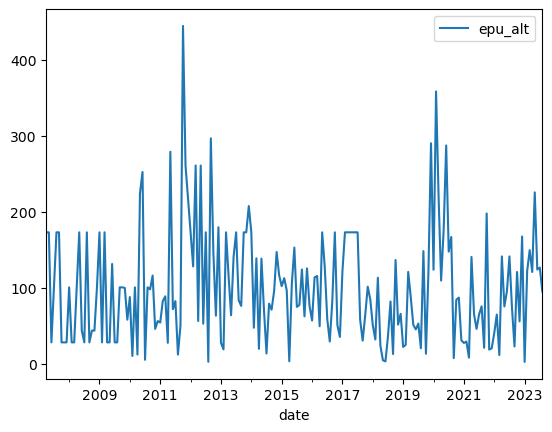

In [7]:
stats_alt = stats.copy()
stats_alt["news_count"] = stats_alt[["st_news_count", "ss_news_count", "tis_news_count", "sibc_news_count"]].mean(axis=1)
stats_alt["epu_count"] = stats_alt[["st_epu_count", "ss_epu_count", "tis_epu_count", "sibc_epu_count"]].mean(axis=1)
stats_alt["z_score_alt"] = get_epu_zscore(stats_alt)
sf_alt = 100/(stats_alt["z_score_alt"].mean())
stats_alt["epu_alt"] = sf_alt * stats_alt["z_score_alt"]
stats_alt.plot(x="date", y="epu_alt");

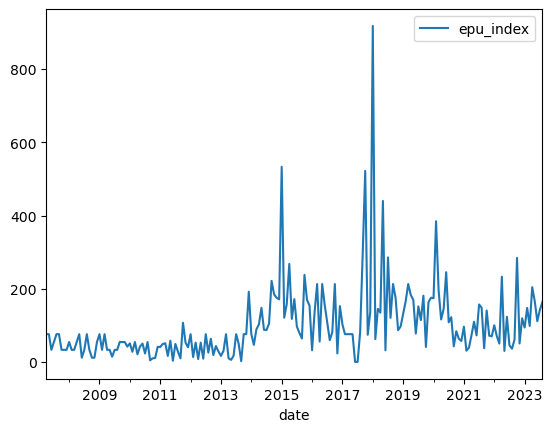

In [8]:
stats.plot(x="date", y="epu_index");